# Classification
The AudioMNIST dataset contains recordings of spoken digits (0-9) by 60 speakers, with a total of 30,000 audio samples.

This notebook trains a ResNet50 instance to predict the spoken digit from each recording, based on spectrogram representations obtained by short-time Fourier transformations of the recorded waveforms. The trained network is evaluated against 12 (20%) of the speakers, withheld as validation set from training.

In [1]:
### Download AudioMNIST data
!wget https://github.com/soerenab/AudioMNIST/archive/refs/heads/master.zip
!unzip master.zip --quiet

--2023-02-10 17:10:16--  https://github.com/soerenab/AudioMNIST/archive/refs/heads/master.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/soerenab/AudioMNIST/zip/refs/heads/master [following]
--2023-02-10 17:10:16--  https://codeload.github.com/soerenab/AudioMNIST/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 20.205.243.165
Connecting to codeload.github.com (codeload.github.com)|20.205.243.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip.3’

master.zip.3            [    <=>             ] 948.50M  7.48MB/s    in 2m 5s   

2023-02-10 17:12:22 (7.57 MB/s) - ‘master.zip.3’ saved [994575418]

Archive:  master.zip
3c9ed8cfcdee9de04c1f61658dbc0883b5b7d781
caution: filename not matched:  --quiet


In [2]:
### Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import torch
from torchvision.models import resnet50, ResNet50_Weights
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn
from torch.utils import data
from IPython.display import clear_output
from sklearn.metrics import confusion_matrix
from IPython.display import Audio

In [3]:
### Find all .wav files
path_in = "AudioMNIST-master/data/"
paths_wav = []

for path, subdirs, files in os.walk(path_in):
    for name in files:
        if ".wav" in name:
          paths_wav.append(os.path.join(path, name))

In [4]:
### Define parameters for short-time fourier transform
stft_param = {}
stft_param["nfft"] = nfft = 256
stft_param["hop"] = nfft // 2

In [5]:
### Convert waveform signal to spectrum using short-time fourier transform
def wav_to_stft_spectrum(signal, nfft, hop, max_width=None):
  S = librosa.stft(signal, n_fft=nfft, hop_length=hop)
  D = librosa.amplitude_to_db(np.abs(S), ref=np.max)

  # If desired, crop spectrum if recording is too long
  if max_width and D.shape[1] > max_width:
      D = D[:, :max_width]

  return D      

Text(0, 0.5, 'Frequency (kHz)')

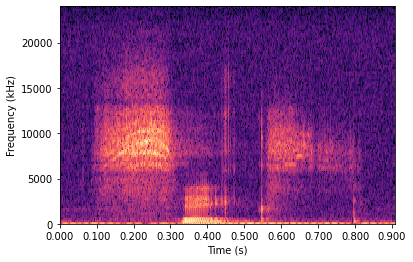

In [6]:
### Visualize spectrogram for one image
wav_idx = 15
signal, sr = librosa.load(paths_wav[wav_idx], sr=None)
D = wav_to_stft_spectrum(signal, stft_param["nfft"], stft_param["hop"])

f, ax = plt.subplots(1, 1)

spec = librosa.display.specshow(D, 
          x_axis='time', 
          y_axis='linear', 
          sr=sr, 
          hop_length=stft_param["hop"],
          ax=ax,
          cmap='magma',
          vmin=np.min(D),
          vmax=0) 
ax.set_xlabel('Time (s)')
ax.set_ylabel('Frequency (kHz)')

# Uncomment to listen to visualized clip
#wn = Audio(paths_wav[wav_idx], autoplay=True)
#display(wn)

In [7]:
### Store spectrogram image representation of each waveform
N = len(paths_wav) # Number of samples
C = 3 # Number of channels
H = 129 # Spectrogram height
W = 375 # Spectrogram width

path_out = "spectral_data/"
if not os.path.exists(path_out): os.makedirs(path_out)

# Define short-time fourier transform parameters
nfft = 256
hop = nfft // 2

img_paths = []

# For each recording
for i in range(N):

  signal, sr = librosa.load(paths_wav[i], sr=None)
  D = wav_to_stft_spectrum(signal, nfft, hop, W)

  # Pad / Crop to shape H x W, assuming H is correct
  padding = W - D.shape[1]
  if padding > 0:
    D = np.hstack((D, np.zeros((H, padding))))
  else:
    D = D[:, :W]

  # 
  path_out_i = os.path.basename(paths_wav[i]).replace(".wav", ".npy")

  np.save(path_out_i, D)
  img_paths.append(path_out_i)

In [8]:
### Data loader
class DigitSpectrogramDataset(data.Dataset):
 
    def __init__(self, img_paths, labels):
        self.labels = labels
        self.img_paths = img_paths

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, index):

        img_path = self.img_paths[index]
        img = np.load(img_path)

        # Add dummy channel for shape C x H x W
        img = img[np.newaxis, ...]

        # Replicate to 3 channels to benefit from pre-trained weights
        img = np.vstack((img, img, img)) 

        Y = int(self.labels[index])

        # Convert images to pytorch tensors
        X = Variable(torch.from_numpy(img)).float()

        name = os.path.basename(self.img_paths[index])

        return X, Y, name

In [9]:
### Assign labels to all samples, corresponding to the pronounced digit
img_labels = np.zeros(N).astype(np.uint8)

# Infer digits from file names
for i in range(N):
  file_name_i = os.path.basename(paths_wav[i])
  img_labels[i] = int(file_name_i.split("_")[0])

In [10]:
##### Create randomized training/validation split on speaker level

# Determine speaker of each sample from filename
speakers = [os.path.basename(f.split("_")[1]) for f in img_paths]

img_paths = np.array(img_paths)
speakers = np.array(speakers)

# Isolate unique speaker IDs
speakers_uq = np.unique(speakers)
S = len(speakers_uq)

# Select random speakers
np.random.shuffle(speakers_uq)

train_share = 0.8
first_val = int(S * train_share)

speakers_train = speakers_uq[:first_val]
speakers_val = speakers_uq[first_val:]

# Split samples according to speaker selection
mask_train = np.in1d(speakers, speakers_train)
img_paths_train = img_paths[mask_train]
img_labels_train = img_labels[mask_train]

mask_val = np.in1d(speakers, speakers_val)
img_paths_val = img_paths[mask_val]
img_labels_val = img_labels[mask_val]

print(f"Split {N} samples in to {len(img_paths_train)} vs {len(img_paths_val)} train/val")

Split 30000 samples in to 24000 vs 6000 train/val


In [11]:
### Plotting loss curves
def plot_losses(losses_train, losses_val, losses_val_it):

  losses_train = np.array(losses_train).astype("float")
  losses_val = np.array(losses_val).astype("float")
  
  # Plot losses
  plt.close()
  clear_output()    

  f, ax1 = plt.subplots(figsize = (12, 4)) 

  ax1.plot(losses_train)
  ax1.set_ylabel("Training loss", color="C0")

  ax2 = ax1.twinx()
  ax2.plot(losses_val_it, losses_val, color="C1")
  ax2.set_ylabel("Validation loss", color="C1")

  ax.grid(True, axis="y")
  plt.show()

In [12]:
### Get pre-trained ResNet50
def initialize_network(class_count):

  net = resnet50(weights=ResNet50_Weights.DEFAULT)
  net.fc = nn.Linear(net.fc.in_features, class_count)

  return net

In [16]:
def get_data_loader(img_paths, img_labels, do_shuffle):
  dataset = DigitSpectrogramDataset(img_paths, img_labels)
  loader = torch.utils.data.DataLoader(dataset,
                                    num_workers=1,
                                    batch_size=B,
                                    shuffle=do_shuffle,
                                    pin_memory=True,
                                    # use different random seeds for each worker
                                    # courtesy of https://github.com/xingyizhou/CenterNet/issues/233
                                    worker_init_fn = lambda id: np.random.seed(torch.initial_seed() // 2**32 + id) )

  return loader

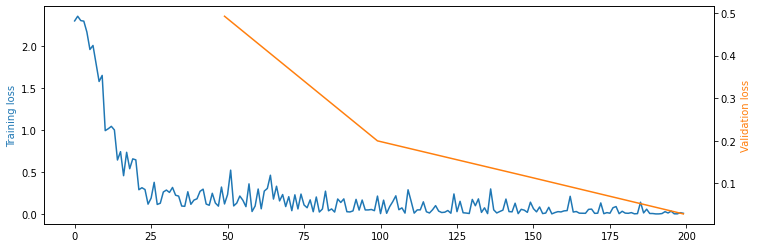

In [17]:
### Train network
net = initialize_network(class_count = 10)

B = 32 # batch size

lr = 0.001 # learning rate
lr_exponent = 0.9 # exponent for poly learning rate policy

I = 200 # training iterations
I_val = 50 # validate after this many iterations

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters(), lr=lr)

# Get training data loader
loader_train = get_data_loader(img_paths_train, img_labels_train, do_shuffle=True)
loader_val = get_data_loader(img_paths_val, img_labels_val, do_shuffle=False)

#
net.train()
net = net.cuda()

losses_train = []

losses_val = [] # Mean loss across full validation set
losses_val_it = [] # Iteration index of validation loss values

i = 0
while i < I:

    for X, Y, _ in loader_train:

        if i >= I: break
        i += 1

        X = X.cuda(non_blocking=True)
        Y = Y.cuda(non_blocking=True)

        optimizer.zero_grad()

        outputs = net(X)

        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()

        losses_train.append(loss.detach().item())

        # Use poly learning policy
        lr_i = optimizer.param_groups[0]['lr'] 
        optimizer.param_groups[0]['lr'] = lr * (1 - i / I)**lr_exponent

        # Validate at current snapshot        
        if i > 1 and (i % I_val) == 0:
            
            net.eval()

            with torch.no_grad():

              losses_val_snapshot = []

              for X, Y, name in loader_val:

                X = X.cuda(non_blocking=True)
                Y = Y.cuda(non_blocking=True)    

                outputs = net(X)
                loss = criterion(outputs, Y)    

                losses_val_snapshot.append(loss.detach().item())
              
              # Aggregate to mean validation loss at current snapshot
              losses_val.append(np.mean(losses_val_snapshot))
              losses_val_it.append(i-1)

              plot_losses(losses_train, losses_val, losses_val_it)
            
            net.train()

Overall accuracy (validation): 99.2%
Predicted 5953 correctly, 47 incorrectly


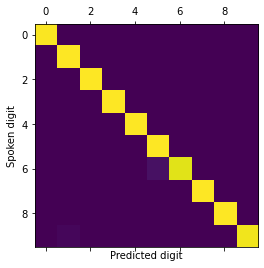

In [18]:
# Plot confusion matrix
with torch.no_grad():

  net.eval()

  class_count = 10

  all_gt = [] # Spoken digits
  all_out = [] # Predicted digits

  count = 0
  for X, Y, _ in loader_val:

    X = X.cuda(non_blocking=True)
    Y = Y.cuda(non_blocking=True)

    outputs = net(X)

    gt = Y.cpu().data.numpy().astype(np.int32)

    out = torch.argmax(outputs, dim=1)
    out = out.cpu().data.numpy()

    all_gt.extend(gt)
    all_out.extend(out)
    
  confusion_mat = confusion_matrix(all_gt, all_out)

  # Plot confusion matrix
  plt.matshow(confusion_mat)
  plt.xlabel('Predicted digit')
  plt.ylabel('Spoken digit')

  # Calculate numerical metrics
  predicted_true = np.sum(np.diag(confusion_mat))
  predicted_false = np.sum(confusion_mat) - predicted_true

  accuracy =  predicted_true / np.sum(confusion_mat)
  print(f"Overall accuracy (validation): {100*accuracy:0.1f}%")
  print(f"Predicted {predicted_true} correctly, {predicted_false} incorrectly")